In [ ]:
# README
# RUN THIS FIRST TO build necessary packages
ENV["PYTHON"]="/usr/bin/python3"
using Pkg
Pkg.add("PyCall")
Pkg.build("PyCall")
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("StatsPlots")

============Env============
environment: means

[6.300732022102932, 8.310849119300398, 2.6974120304182536, 4.214007522027688, 6.490507391868368, 3.489222671504745, 6.453040013668321, 2.107409304744956, 5.820941336435102, 7.543383195107044]
============vanilla-epsilon-greedy============


number of actions taken, per action: [10.0, 0.0, 2.0, 2.0, 76.0, 1.0, 5.0, 3.0, 1.0, 0.0] each action's q value: [6.286641512007022, 0.0, 2.705169062650386, 4.2502525839155965, 6.4818603358394125, 3.4378209251749894, 6.476275596822847, 2.117625496755918, 5.743561202074376, 0.0]
============decaying-epsilon-greedy============


number of actions taken, per action: [96.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0] each action's q value: [6.3038473392311465, 0.0, 0.0, 4.181881351790427, 0.0, 0.0, 0.0, 2.1162741752802248, 0.0, 0.0]
============optimistic-decaying-epsilon-greedy============
number of actions taken, per action: [4.0, 87.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 8.0] each action's q value: [6.3174614829430755, 8.310202474702619, 5.0, 5.0, 5.0, 3.5218006330148013, 5.0, 5.0, 5.0, 7.547134599865946]
============ucb_optimistic_decaying_epsilon============
number of actions taken, per action: [48.0, 25.0, 0.0, 3.0, 23.0, 0.0, 0.0, 1.0, 0.0, 0.0] each action's q value: [6.295566795300804, 8.310421141085907, 5.0, 4.280901993942417, 6.489662291377934, 5.0, 5.0, 2.0065297454776503, 5.0, 5.0]
============SGA============


policies per action: [0.1, 0.10000000000000005, 0.10000000000000003, 0.1, 0.09999999999999991, 0.09999999999999996, 0.0999999999999999, 0.10000000000000012, 0.09999999999999998, 0.1] each action's h value: [2.0816681711721685e-16, 7.216449660063518e-16, 5.273559366969494e-16, 3.0531133177191805e-16, -8.326672684688674e-16, -2.7755575615628914e-16, -8.604228440844963e-16, 1.27675647831893e-15, -3.469446951953614e-17, 4.440892098500626e-16]


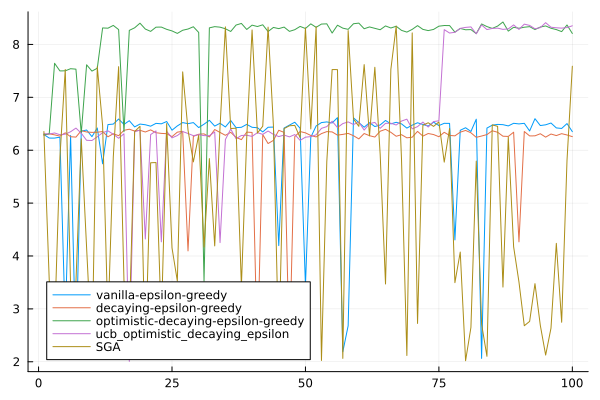

In [4]:
using PyCall
using Libdl
using Plots
include("k_armed_bandits.jl")
plot()

STEP_CAP = 100
STD_DEV = 0.05
EPISODE_NUM = 1
# add current directory to search path
pushfirst!(PyVector(pyimport("sys")["path"]), "")
environments = pyimport("k_armed_bandits_env")
KArmedBanditsEnv = environments.KArmedBanditsEnv
env = KArmedBanditsEnv(STEP_CAP, STD_DEV)

function train(get_action, label_name, stochastic_gradient_method=false)
    env.reset()
    if stochastic_gradient_method
        agent_data = init_agent_data_SGA(env.get_k())
    else
        agent_data = init_agent_data(env.get_k())
    end

    for e in 1: EPISODE_NUM
        while true
            action = get_action(agent_data)
            observation, reward, terminated, trucacted = env.step(action)
            if stochastic_gradient_method
                update_agent_data_SGA!(agent_data, reward, action)
            else
                update_agent_data!(agent_data, reward, action)
            end
            if terminated == true
                break
            end
            env.render()
        end
    end

    env.close()

    if stochastic_gradient_method
        println("============$label_name============")
        println("policies per action: ", agent_data.pi, " each action's h value: ", agent_data.h)
    else
        println("============$label_name============")
        println("number of actions taken, per action: ", agent_data.action_nums, " each action's q value: ", agent_data.q)
    end

    filter!(lib -> occursin("glib", lib), dllist())
    x = 1:STEP_CAP
    y = agent_data.rewards_history
    if stochastic_gradient_method
        y = y[2:end]
    end
    plot!(x,y, label=label_name)
end
println("============Env============")
println("environment: means", env.means)

decaying_epsilon = agent_data -> get_action_decaying_epsilon(agent_data, false, false)
optimistic_decaying_epsilon = agent_data -> get_action_decaying_epsilon(agent_data, true, false)
ucb_optimistic_decaying_epsilon = agent_data -> get_action_decaying_epsilon(agent_data, true, true)
train(get_action, "vanilla-epsilon-greedy")
train(decaying_epsilon, "decaying-epsilon-greedy")
train(optimistic_decaying_epsilon, "optimistic-decaying-epsilon-greedy")
train(ucb_optimistic_decaying_epsilon, "ucb_optimistic_decaying_epsilon")
train(get_action_SGA, "SGA", true)

### Experiments
As shown above, the decaying epsilon greedy method provides a more stable reward per step.
If the environment is non-stationary, i.e., the distribution of mean and standard deviation changes, then we can have a "non-stationarity" detection, and reset $\epsilon$ as needed
- Higher initial value will be an "optimistic" guess, and will set $(R-Q)$ to negative at the initial few steps. So, that encourages exploration. However, note that optimistic initial values may set the true values lower than they are. So, if your epsolon is set such that later there's no exploration, it might get stuck in a sub-optimal state.
- UCB: depends on the landscape of the reward distribution, this may or may not get stuck in local minima